In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [5]:
reduced_dataset_folder = '/home/usuario/repos/Object_Localization/challenge_dataset'
train_folder = reduced_dataset_folder + '/images/train'
val_folder = reduced_dataset_folder + '/images/val'
annotations_dict_train = np.load(reduced_dataset_folder+'/annotations_train.npy').flat[0]
annotations_dict_val = np.load(reduced_dataset_folder+'/annotations_val.npy').flat[0]
classes = list(annotations_dict_train.keys())
print(classes)

['n04487081', 'n02108089', 'n02701002', 'n02279972', 'n04008634']


In [27]:
from object_detection_helper import GeneratorMultipleOutputs, plot_batch, PlotLosses

In [32]:
# classes en None para que tome world tambien
train_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_train, 
                                                            train_folder, 10, classes = None,
                                                            concat_output = True
                                                           )
val_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_val, 
                                                              val_folder, 64, classes = None,
                                                              concat_output = True
                                                         )

Found 2500 images belonging to 6 classes.
Found 500 images belonging to 6 classes.


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


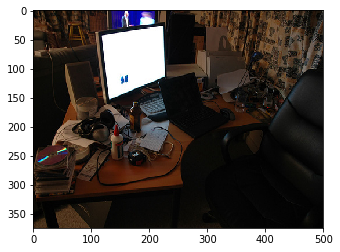

[0.   0.   0.   0.   1.   0.45 0.7  0.54 0.51 1.  ]


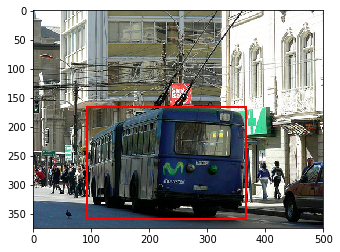

[0.   0.   0.   0.   1.   0.47 0.42 0.64 0.57 1.  ]


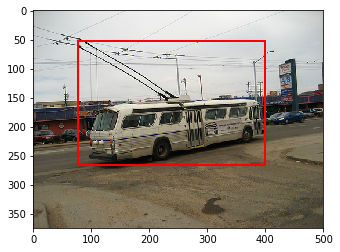

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


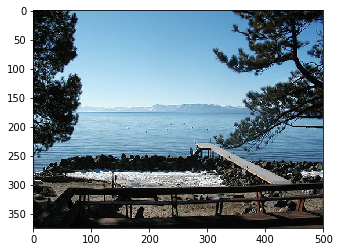

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


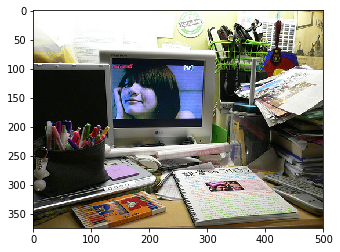

[0.   0.   1.   0.   0.   0.5  0.5  0.99 0.7  1.  ]


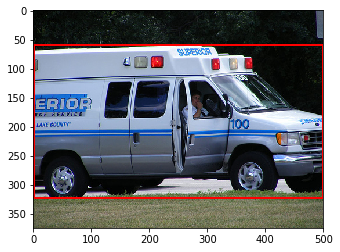

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


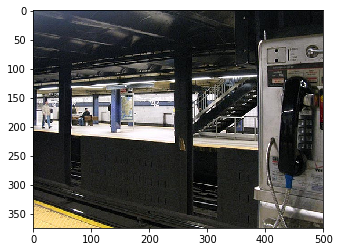

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


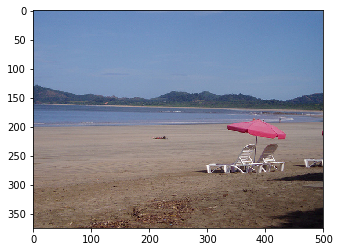

[0.   1.   0.   0.   0.   0.23 0.66 0.46 0.66 1.  ]


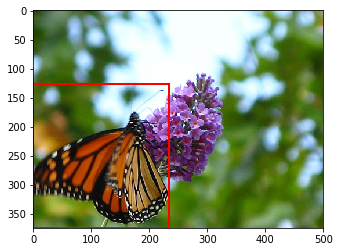

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


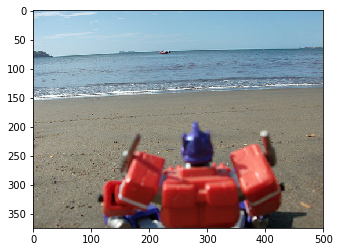

In [33]:
plot_batch(train_generator_multiple_outputs, count=10)

In [38]:
from object_detection_helper import get_VGG16_world

In [73]:
n_classes = 5
model = get_VGG16_world(n_classes = n_classes, N_trainable = 17, dropout_class = 0.5, dropout_confidence = 0.5, dropout_bbox = 0.25)

In [74]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 375, 500, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 375, 500, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 375, 500, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 187, 250, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [75]:
from custom_losses import custom_loss_IOU, classes_acc, confidence_acc, bounding_box_mse, iou_v2, cat_cross_entropy_loss, custom_loss, mse_custom_loss

In [76]:
#losses = {"concatenated_outputs": mse_custom_loss}
losses = {"concatenated_outputs": custom_loss}

metrics = {"concatenated_outputs": [classes_acc, confidence_acc, bounding_box_mse, iou_v2, cat_cross_entropy_loss]}

In [77]:
train_generator = GeneratorMultipleOutputs(annotations_dict_train, 
                                           train_folder, 
                                           concat_output = True,
                                           batch_size=50, 
                                           flip = 'random')
val_generator = GeneratorMultipleOutputs(annotations_dict_val, 
                                         val_folder, 
                                         concat_output = True,
                                         batch_size=50,  
                                         flip = 'random')

Found 2500 images belonging to 6 classes.
Found 500 images belonging to 6 classes.


In [78]:
train_generator.generator.n % train_generator.generator.batch_size

0

In [79]:
val_generator.generator.n % val_generator.generator.batch_size

0

In [70]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, rmsprop, SGD
filename = 'runtime'
checkpoint = ModelCheckpoint(filepath = filename+'_best.hdf5', 
                             monitor='val_classes_acc', save_best_only=True)
model.compile(loss=losses,
              optimizer=Adam(lr=0.001),
              metrics=metrics,
              loss_weights = lossWeights)

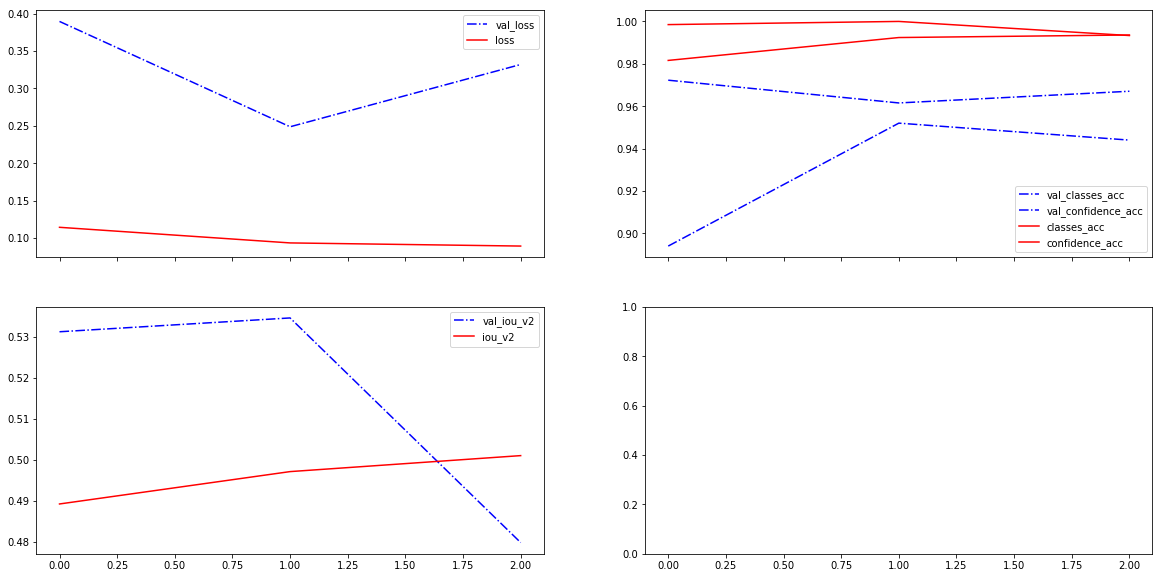

Epoch 4/2000
21/50 [===========>..................] - ETA: 15s - loss: 0.0783 - classes_acc: 1.0000 - confidence_acc: 0.9962 - bounding_box_mse: 0.0182 - iou_v2: 0.5030 - cat_cross_entropy_loss: 0.0192

KeyboardInterrupt: 

In [71]:
plot_losses = PlotLosses(1)
model.fit_generator(
        train_generator,
        epochs=2000,
        validation_data=val_generator, callbacks = [plot_losses, checkpoint]
        )

Confidence OK: 0.0056234645


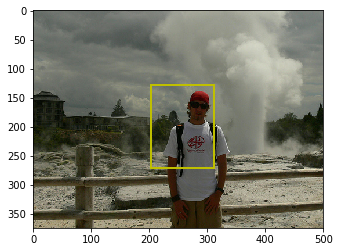

Confidence OK: 0.9988433
Class OK: 2
IOU: [0.5359411]


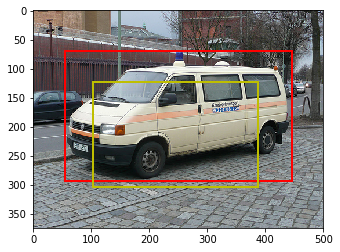

Confidence OK: 0.0005132085


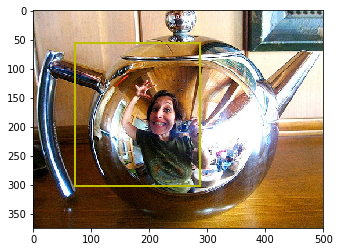

Confidence OK: 0.0031816533


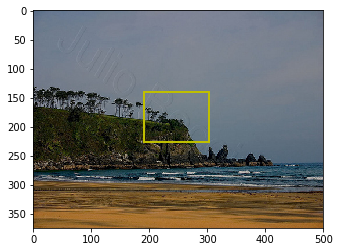

Confidence OK: 0.9380756
Class OK: 0
IOU: [0.50948231]


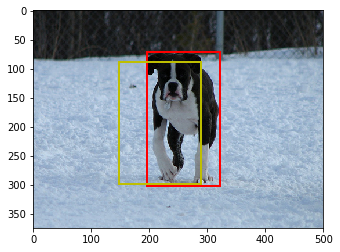

Confidence OK: 0.99165183
Class OK: 3
IOU: [0.35423891]


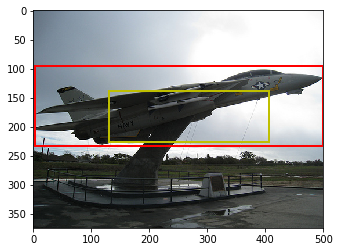

Confidence OK: 0.0009305014


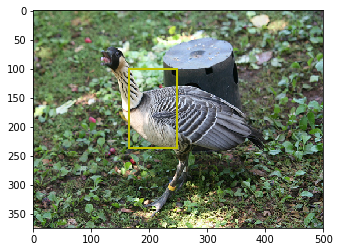

Confidence OK: 0.99657416
Class OK: 4
IOU: [0.31475615]


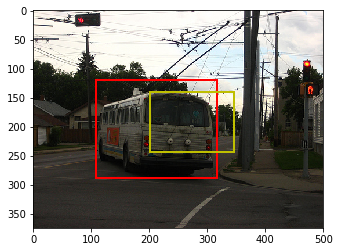

Confidence OK: 0.00036691962


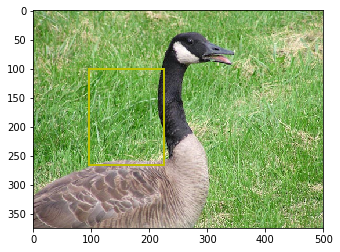

Confidence OK: 0.99873656
Class OK: 2
IOU: [0.60890799]


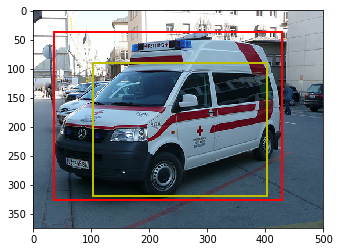

In [72]:
plot_batch(train_generator_multiple_outputs, model, count=10)